# 미니 프로젝트: 가위바위보 분류기

1. 데이터 준비
2. 네트워크 설계
3. 네트워크 훈련
4. 실험 결과

## 1. 데이터 준비

1. 여러 출처에서 가위, 바위, 보에 해당하는 이미지들을 수집
2. k-fold cross-validation을 통한 성능 평가를 위하여 훈련 데이터와 테스트 데이터를 분리
   1. 같은 출처에서 얻은 데이터는 서로 다른 fold에 속할 수 없음  
      예시) (Fold 1) 출처1, 출처2, ... (Fold 2) 출처3, 출처4, ...
   2. keras 제공 flow_from_directory를 사용하기 위하여 각 fold에 해당하는 이미지들을 별도의 경로에 복사

In [6]:
import glob, os, shutil
from itertools import chain
import matplotlib.pyplot as plt
from PIL import Image

categories = ["rock", "paper", "scissors"]


def chunk(big, n):
    for i in range(0, len(big), n):
        yield big[i : i + n]


def prepare_directory(list_dir, mode="train"):
    if mode == "train":
        dir_name = "train"
    else:
        dir_name = "test"
    shutil.rmtree(dir_name, ignore_errors=True)
    os.mkdir(dir_name)
    for cat in categories:
        idx = 0
        os.mkdir(f"{dir_name}/{cat}")
        for dir in list_dir:
            img_fs = glob.glob(f"{dir}/{cat}/*")
            for img_f in img_fs:
                shutil.copy(img_f, f"{dir_name}/{cat}/{idx}.jpg")
                idx += 1


dir_sets = glob.glob("data/*")
num_sets = len(dir_sets)
# print(num_sets)
myfold = 4
folded = list(chunk(dir_sets, num_sets // myfold))

list_dir_train = []
list_dir_test = []

for fold in range(myfold):
    dir_train = [x for (idx, x) in enumerate(folded) if not idx == fold]
    dir_train.append(["data_ext"])
    dir_test = [x for (idx, x) in enumerate(folded) if idx == fold]
    list_dir_train.append(list(chain.from_iterable(dir_train)))
    list_dir_test.append(list(chain.from_iterable(dir_test)))

# print(list_dir_train)
# print(list_dir_test)


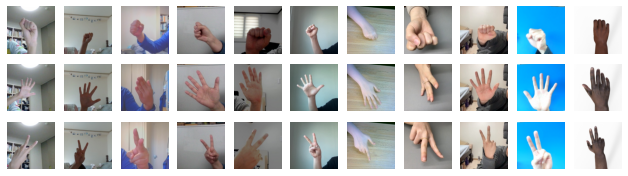

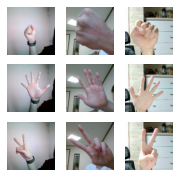

In [7]:
rows = 3

img_loc = []
for cat in ["rock", "paper", "scissors"]:
    each_row = []
    for directory in list_dir_train[-1]:
        each_row.append(list(glob.glob(f"{directory}/{cat}/*"))[-3])
    img_loc.append(each_row)
cols = len(list_dir_train[0])
fig = plt.figure(figsize=(cols, 3))
for i in range(rows):
    for j in range(cols):
        img = Image.open(img_loc[i][j])
        ax = fig.add_subplot(rows, cols, j + i * cols + 1)
        ax.imshow(img)
        ax.set_axis_off()

img_loc = []
for cat in ["rock", "paper", "scissors"]:
    each_row = []
    for directory in list_dir_test[-1]:
        each_row.append(list(glob.glob(f"{directory}/{cat}/*"))[-3])
    img_loc.append(each_row)
cols = len(list_dir_test[0])
fig = plt.figure(figsize=(cols, 3))
for i in range(rows):
    for j in range(cols):
        img = Image.open(img_loc[i][j])
        ax = fig.add_subplot(rows, cols, j + i * cols + 1)
        ax.imshow(img)
        ax.set_axis_off()



### 데이터 증강

- 이미지의 정규화
- 좌우반전, 상하반전을 적용하여 이미지 증강
- 테스트 데이터와 별개로, 훈련 데이터의 20%를 검증 데이터로 사용

In [8]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


def schedule_(epoch, lr):
    peak = 3
    if epoch < peak:
        return lr
    else:
        return lr * 0.90


# https://stackoverflow.com/a/61304850
def rotation(img):
    return np.rot90(img, np.random.choice([-1, 0, 1]))


batch = 128
epochs = 30

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    vertical_flip=True,
    # preprocessing_function=rotation,
    validation_split=0.2,
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

gen_args = {
    "color_mode": "rgb",
    "batch_size": batch,
    "class_mode": "categorical",
}


## 2. 네트워크 설계
- 분류할 클래스의 수가 적어 MNIST 데이터셋의 이미지와 동일한 크기를 입력 크기로 사용하고 2개의 convolution 레이어 사용

In [9]:
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential


def cnn(channel=32, size=(28, 28), opt="adam", n_class=3):
    model = Sequential(
        [
            Conv2D(
                channel,
                (3, 3),
                activation="relu",
                input_shape=(size[0], size[1], 3),
                padding="same",
            ),
            MaxPooling2D((2, 2)),
            Conv2D(channel * 2, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation="relu"),
            # Dropout(0.5),
            Dense(n_class, activation="softmax"),
        ]
    )
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model


cnn().summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                147520    
_________________________________________________________________
dense_25 (Dense)             (None, 3)               

## 3. 네트워크 훈련
- validation accuracy가 가장 높은 모델의 상태를 저장하도록 ModelCheckpoint 사용
- validation loss가 증가하며 과적합 양상을 보이면 학습을 중단하도록 EarlyStopping 사용
- 특정 epoch 이후 learning rate를 서서히 감소시키는 Learning Rate Scheduling 기법 사용

In [10]:
import csv
from itertools import product
from tqdm import tqdm
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    LearningRateScheduler,
)
from keras.models import load_model

stopper = EarlyStopping(monitor="val_loss", patience=epochs // 4, verbose=0)
reduce_lr = ReduceLROnPlateau()
scheduler = LearningRateScheduler(schedule_, verbose=0)


# params = [
#     [28],
#     [32, 64],
#     ["adam", "rmsprop"],
#     [cnn],
# ]

params = [[28], [64], ["rmsprop"], [cnn]]


for size, channel, opt, model_loader in product(*params):
    target_size = (size, size)

    acc_test = []
    loss_test = []

    check_pointer = ModelCheckpoint(
        f"models/{model_loader.__name__}-{size}-{channel}-{opt}.h5",
        verbose=0,
        save_best_only=True,
    )

    for fold in tqdm(range(myfold)):
        # print(f"                Fold No. {fold}")

        prepare_directory(list_dir_train[fold])
        prepare_directory(list_dir_test[fold], mode="test")

        gen_args["target_size"] = target_size

        train_args = gen_args.copy()
        valid_args = gen_args.copy()
        test_args = gen_args.copy()

        train_args["directory"] = "train"
        train_args["subset"] = "training"
        train_generator = train_datagen.flow_from_directory(**train_args)

        valid_args["directory"] = "train"
        valid_args["subset"] = "validation"
        valid_generator = train_datagen.flow_from_directory(**valid_args)

        model = model_loader(channel=channel, size=target_size, opt=opt)
        model.fit(
            train_generator,
            validation_data=valid_generator,
            callbacks=[
                check_pointer,
                stopper,
                scheduler,
            ],
            epochs=epochs,
            verbose=0,
        )

        test_args["directory"] = "test"
        test_generator = test_datagen.flow_from_directory(**test_args)

        model = load_model(f"models/{model_loader.__name__}-{size}-{channel}-{opt}.h5")
        test_loss, test_acc = model.evaluate(test_generator, verbose=0)
        acc_test.append(test_acc)
        loss_test.append(test_loss)

    # print([f"{x:.3f}" for x in acc_test])
    msg = f"{model_loader.__name__}, {target_size}, {channel}, {opt}, {np.array(acc_test).mean():.3f}"
    # print(msg)
    with open("results/exp.csv", "a", newline="") as f:
        wr = csv.writer(f)
        wr.writerow(
            [
                model_loader.__name__,
                size,
                channel,
                opt,
                f"{np.array(acc_test).mean():.3f}",
            ]
        )
        wr.writerow([f"{x:.3f}" for x in acc_test])


  0%|          | 0/4 [00:00<?, ?it/s]

Found 4433 images belonging to 3 classes.
Found 1107 images belonging to 3 classes.
Found 911 images belonging to 3 classes.


 25%|██▌       | 1/4 [01:52<05:38, 112.86s/it]

Found 4442 images belonging to 3 classes.
Found 1109 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


 50%|█████     | 2/4 [03:26<03:23, 101.75s/it]

Found 4440 images belonging to 3 classes.
Found 1108 images belonging to 3 classes.
Found 903 images belonging to 3 classes.


 75%|███████▌  | 3/4 [04:45<01:31, 91.29s/it] 

Found 4429 images belonging to 3 classes.
Found 1105 images belonging to 3 classes.
Found 917 images belonging to 3 classes.


100%|██████████| 4/4 [06:53<00:00, 103.47s/it]


## 4. 실험 결과

### 1. 초기 실험 결과

- 데이터
    - 4,400여 장의 이미지로 훈련 데이터 구성
    - 클래스 당 평균 1,470장의 이미지
    - [특정 데이터](https://laurencemoroney.com/datasets.html)는 cross validation을 위한 과정에서 테스트 데이터로 선택하지 않고 항상 트레이닝 데이터에 포함시킴
      - 그래픽으로 그려진 데이터로써 배경과 같이 분류 성능에 악영향을 미칠 요소들이 포함되어 있지 않아 학습에 유리한 데이터로 판단
- 네트워크 구조
    - 이미지 크기: 28x28
      - 분류할 클래스의 수가 적어 MNIST 데이터셋의 이미지와 동일한 크기 사용
    - 분류할 클래스의 수가 적어 2개의 Convolution 레이어 사용
    - 각 convolution 레이어의 채널 수: (16, 32)
    - 최적화 함수: adam
- 평균 정확도 68.8%
  - 선택된 데이터셋에 따라 최저 36.1%에서 최고 94.8%의 정확도를 보임
-  validation loss가 증가하며 validation accuracy가 낮아지는 overfitting은 관측되지 않음

### 2. 데이터 증강

- 성능 향상을 위해 데이터 증강
  - 데이터에 상하반전, 좌우반전을 적용
- 평균 정확도 55.2%
  - 선택된 데이터셋에 따라 최저 37.0%에서 최고 89.8%의 정확도를 보임
  - 데이터 증강 이전과 비교하여 정확도 하락
- 증강된 데이터 대비 모델의 복잡도가 낮은 것으로 판단

### 3. 모델 복잡도 조절

- 데이터 증강을 적용한 상황에서, 성능 향상을 목적으로 모델 복잡도 상승시킴
  - convolultion 레이어 채널 (16, 32) -> (32, 64)
- 평균 정확도 68.6%
  - 선택된 데이터셋에 따라 최저 42.4%에서 최고 91.2%의 정확도를 보임
  - 최저 정확도 6% 가량 상승

### 4. Learning Rate Scheduling 적용

- 추가적인 성능 향상을 위해 Learning Rate Scheduling 적용
  - 특정 epoch 이후 learning rate를 epoch마다 감소시킴
- 평균 정확도 71.9%
  - 선택된 데이터셋에 따라 최저 40.7%에서 최고 98.9%의 정확도를 보임
- validation loss가 수렴하지 않고 커지는 overfitting 경향 관측

### 5. Dropout 적용

- 훈련 과정에서 일부 연결을 사용하지 않는 Dropout 레이어를 추가하여 과적합 문제 해결 시도
- 평균 정확도 71.6%
  - 선택된 데이터셋에 따라 최저 41.1%에서 최고 93.9%의 정확도를 보임
- 성능 향상에 도움이 되지 않았음

### 6. 하이퍼파라미터 변경

- 데이터 증강과 LR Scheduling은 유지하면서 convolution 레이어 채널 수 및 최적화 함수 변경 실험
  - convolution 레이어 채널 수: (32, 64), (64, 128)
  - 최적화 함수: rmsprop, adam
- convolution 레이어의 채널 수가 (64, 128)이면서 rmsprop을 사용한 경우 평균 정확도가 86.4%로 가장 높았음
  - 선택된 데이터셋에 따라 최저 61.2%에서 최고 97.8%의 정확도를 보임

## 결론
- 분류해야할 클래스의 숫자를 기반으로 입력 이미지 크기와 모델 복잡도 설정
- 일반화 능력을 평가하기 위해 k-fold cross validation 수행 계획, 이를 위해 데이터를 훈련 데이터와 테스트 데이터로 분할
- 최소 훈련 설정에서 높지 않은 성능을 보여 모델 복잡도를 증가시키고, 데이터 증강 기법 사용
  - 최초 시도와 비교하여 정확도 향상
- 추가적인 정확도 증가를 위하여 epoch에 따라 학습률을 변화시키는 기법을 사용
  - 이전 시도와 비교하여 정확도 향상
- 정확도가 향상되었던 이전 설정에 더해, 다른 최적화 함수 사용 시도
  - 이전 시도와 비교하여 정확도 증가
- 정확도 증가를 위해 적용한 기법들은 효과가 있었다
  - 하지만 가장 높은 정확도를 보여주었던 설정에서도 다른 fold에 속한 데이터에 대해 최저 61.2%에서 최고 97.8%의 정확도를 보임
  - 여러 fold에 속한 데이터에 대해 최저 정확도와 최고 정확도 간의 차이는 최초 설정보다는 줄었지만 여전히 30% 이상
  - 모델의 일반화 능력이 부족하여 나타나는 결과로 모델의 복잡도를 더 세밀하게 수정하거나 추가 데이터를 확보하면 성능이 향상될 것으로 보임

## 평가 루브릭
> 1. 이미지 분류기 모델이 성공적으로 만들어졌는가? - 트레이닝이 정상적으로 수행되었음
> 2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가? - 데이터셋의 다양성, 정규화 등의 시도가 적절하였음
> 3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가? - 60% 이상 도달하였음

### 루브릭에 대한 자체평가
1. 트레이닝 과정 중에 오류가 발생하지 않았고, 원하는 조건을 적용하여 훈련을 진행, 테스트 데이터에 대해 분류 성능 평가를 얻을 수 있었음
2. 출처가 서로 다른 데이터셋을 조합하여 사용하였고, 데이터셋을 훈련/검증/평가 세가지로 나누어 사용
   1. 오버피팅의 경향이 관측되면 훈련을 중단하는 earlystopping 적용
   2. 일반화 능력을 평가하기 위해 교차검증 적용
3. 분류 모델의 정확도를 구하기 위해 4-fold cross-validation을 진행하였고, 평균 정확도 86.4% 달성
   1. 최저 61.2%의 성능을 달성하여, 어떤 fold를 선택하더라도 기준이 되는 60% 이상의 성능 보장